In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144

# Introduction to Statistics

## Statistics vs. Probability

Probability is the study of how (abstract) random variables and distributions behave.  Statistics is the study of how to interpret data while making assumptions about the underlying distributions.  Probability is actually a very formal, precise calculation.  (Applied) statistics is a much more squishy subject that requires human judgment as input.


In [2]:
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pylab as plt

def plot_hist_dist(rvs, dist, title=None, label='', mean=None, confidence_interval=None, ax=None):
    ax = ax if ax else plt.gca()
    _, bins, _ = ax.hist(rvs, bins=50, alpha=.6, normed=True, label=(label + ' rvs').strip(), color='blue')
    xmin, xmax = bins.min(), bins.max()
    xpoints = np.arange(xmin, xmax, (xmax - xmin) / 100)
    ax.plot(xpoints, dist.pdf(xpoints), label=(label+' pdf').strip(), color='black')
    
    if mean is not None:
        ax.plot([mean, mean], plt.ylim(), label='mean', color='purple')

    if confidence_interval:
        ymid = np.sum(plt.ylim()) / 2.
        plt.text(mean, ymid, 'CI', ha='center', va='bottom')
        plt.annotate("", xy=(confidence_interval[0], ymid), xycoords='data',
                     xytext=(confidence_interval[1], ymid), textcoords='data',
                     arrowprops=dict(arrowstyle="|-|", lw=2, color='r'))    

    if title:
        ax.set_title(title)

    ax.legend()
    
def plot_hist_dist_discrete(rvs, dist, title=None, label='', ax=None):
    ax = ax if ax else plt.gca()
    uniques = np.unique(rvs)
    mids = (uniques[1:] + uniques[:-1]) / 2.
    bins = np.hstack([[uniques[0]-.5], mids, [uniques[-1] + .5]])
    plt.hist(rvs, bins=bins, normed=True, label=(label + ' rvs').strip(), alpha=.6, color='blue')
    if title:
        ax.set_title(title)
    plt.plot(uniques, dist.pmf(uniques), label=(label + ' pmf').strip(), color='black')
    ax.legend()

## Estimating Mean

Let's say you have a collection of data $X_1, \ldots, X_n$.  To estimate the mean, you would use the formula for the mean estimator

$$ \overline X = \frac{1}{n} \sum_{k=1}^n X_k. $$

This is implemented by the function `np.mean()` or just the `.mean()` method.

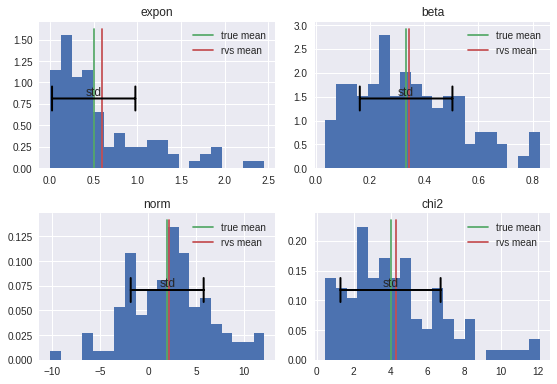

In [3]:
def plot_empirical_dist(dist, size=100):
    X = dist.rvs(size=size)
    mean, var = dist.stats('mv')
    rvs_mean = X.mean()

    plt.hist(X, bins=20, normed=True)
    ymin, ymax = plt.ylim()
    ymid = (ymin + ymax) / 2.
    plt.plot([mean]*2, [ymin, ymax], label='true mean')
    plt.plot([rvs_mean]*2, [ymin, ymax], label='rvs mean')
    plt.text(mean, ymid, 'std', ha='center', va='bottom')
    plt.annotate("", xy=(mean-np.sqrt(var), ymid), xycoords='data',
                 xytext=(mean+np.sqrt(var), ymid), textcoords='data',
                 arrowprops=dict(arrowstyle="|-|", connectionstyle="arc3", lw=2, color='k'))
    plt.title(dist.dist.name)
    plt.legend()
    
dists = (
    sp.stats.expon(scale=1/2.),
    sp.stats.beta(a=2., b=4.),
    sp.stats.norm(loc=2., scale=4.),
    sp.stats.chi2(df=4.)
)

for k, dist in enumerate(dists):
    plt.subplot(2,2,k+1)
    plot_empirical_dist(dist)
plt.tight_layout()

## Estimating Variance

Let's say you have a collection of data $X_1, \ldots, X_n$.  To estimate the variance, one might think the right answer is

$$ \frac{1}{n} \sum_{k=1}^n (X_k - \overline X)^2 $$

where $\overline{X}$ is the mean estimator or the *empirical mean*.  This turns out to be **biased**.  That is, the answer is expected to be be smaller than the true variance.  Mathematically, if we let $\mu$ be the true mean and $\sigma^2$ be the true variance, then
$$
\begin{align}
    \mathbb{E}\left[ \frac{1}{n}\sum_{k=1}^n \left(X_k-\overline{X}\right)^2 \right]
    &= \mathbb{E}\bigg[ \frac{1}{n}\sum_{k=1}^n \big((X_k-\mu)-(\overline{X}-\mu)\big)^2 \bigg] \\[4pt]
    &= \mathbb{E}\bigg[ \frac{1}{n}\sum_{k=1}^n (X_k-\mu)^2 -
                              2(\overline{X}-\mu)(X_k-\mu) +
                              (\overline{X}-\mu)^2 \bigg] \\[4pt]
    &= \mathbb{E}\bigg[ \frac{1}{n}\sum_{k=1}^n (X_k-\mu)^2 - (\overline{X}-\mu)^2 \bigg] \\[4pt]
    &= \sigma^2 - \mathbb{E}\left[ \left(\overline{X}-\mu\right)^2 \right] \\
    &< \sigma^2\,
\end{align}
$$

Mathematically, we can see that
$$
\begin{align}
    \mathbb{E}\left[ \left(\overline{X}-\mu\right)^2 \right]
    &= \mathbb{E}\left[ \left(\frac{1}{n}\sum_{k=1}^n (X_k-\mu)\right)^2 \right] \\[4pt]
    &= \frac{1}{n^2} \sum_{k=1}^n \mathbb{E}\left[ \left(X_k-\mu\right)^2 \right] \\
    &= \frac{\sigma^2}{n}
\end{align}\,
$$
Combining this with the above, we see that 
$$
\begin{align}
    \frac{1}{n-1} \mathbb{E}\left[ \sum_{k=1}^n \left(X_k-\overline{X}\right)^2 \right]
    &= \frac{n}{n-1} \cdot \mathbb{E}\left[ \frac{1}{n} \sum_{k=1}^n \left(X_k-\overline{X}\right)^2 \right] \\[4pt]
    &= \frac{n}{n-1} \cdot \sigma^2 \cdot \left( 1 - \frac{1}{n} \right) \\[4pt]
    &= \sigma^2 \,
\end{align}
$$

Therefore, the **unbiased estimator** of the variance is
$$ \hat\sigma = \frac{1}{n-1} \sum_{k=1}^n (X_k - \overline X)^2\, $$

Both are implemented by `np.var`.  For the former, set the optional parameter `df=0`, the default.  For the latter, set `df=1`.  Nominally, the unbiased estimator is assuming a single degree of freedom.

True variance to unbiased variance 0.00102869239768
True variance to biased variance 0.0239970249123


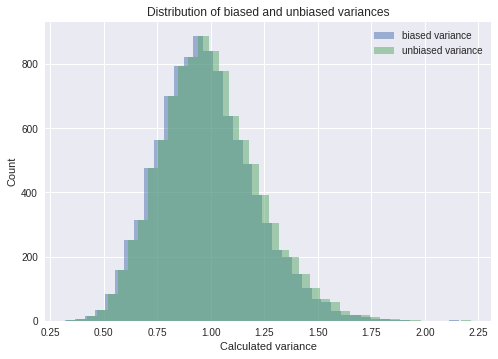

In [4]:
dist = sp.stats.norm()
X = dist.rvs(size=[40, 10000])
_, var = dist.stats('mv')
rvs_var, rvs_var_unbiased  = np.var(X, axis=0), np.var(X, axis=0, ddof=1)

plt.hist(rvs_var, label='biased variance', bins=40, alpha=.5)
plt.hist(rvs_var_unbiased, label='unbiased variance', bins=40, alpha=.5)
plt.legend()
plt.xlabel('Calculated variance')
plt.ylabel('Count')
plt.title("Distribution of biased and unbiased variances")

print "True variance to unbiased variance", np.abs(rvs_var_unbiased.mean() - var)
print "True variance to biased variance", np.abs(rvs_var.mean() - var)

## Standard Error of Mean

As we have seen, an estimate is noisy and (even if unbiased) is not always equal to its expected value.  The obvious question is what is the uncertainty of this.  More appropriately, what is the standard deviation of the distribution of the estimator given our sample size $n$?

It turns out this is really easy.  Let's take our mean estimator $\overline X$ for the sample $X_1, \ldots, X_n$.  The Central Limit Theorem tells us that as $n$ increases, our estimate of $\overline X$ starts to look like the normal distribution:

$$ \overline X \sim N\left(\mu, \frac{\sigma^2}{n} \right) $$

Given an observation and an underlying distribution, the **z-score** measures the number of standard deviations the observation is above the mean.  For the case of the the observation $\overline X$, we expect the z-score
$$ z = \frac{\overline X - \mu}{\sigma / \sqrt{n}} $$
to be distributed as a standard normal (with mean zero and standard deviation one).

**Gotchas:**
- Standard deviation is not standard error!  Don't confuse the two.
- What is the difference between the standard deviation and the standard error?

### Student T Distribution
In real life, we do not know $\sigma$ so we often use $\hat \sigma$, the square root of the estimate for the variance $\sigma^2$.  Because $\hat\sigma$ is now a function of the data, even if $\overline X$ were a normal random variable, the distribution of the z score
$$ z = \frac{\overline X - \mu}{\hat\sigma / \sqrt{n}} $$
is no longer exactly normal but a [**student t** distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) with degrees of freedom $\nu = n - 1$.  The pdf is given by
$$ p(x) = \frac{\Gamma(\frac{\nu+1}{2})} {\sqrt{\nu\pi}\,\Gamma(\frac{\nu}{2})} \left(1+\frac{x^2}{\nu} \right)^{\!-\frac{\nu+1}{2}} \,$$

The distribution satisfies the following **stats:**
- The mean is $\mathbb{E}[X] = 0$
- The variance is $\mbox{Var}[X] = \frac{\nu}{\nu-2}$.

Fortunately as $\nu \to \infty$ (or $n \to \infty$), this approaches the standard normal distribution

$$ \overline X \longrightarrow N\left(\mu, \frac{\sigma^2}{n} \right)\, $$

where $\mu$ and $\sigma$ are the mean and the standard deviation of each of the $X_k$.  So we expect that the **standard error** - the standard deviation of this normal distribution - becomes
$$ s = \frac{\sigma}{\sqrt{n}}\, $$

(Of course, in real life, we do not know $\sigma$ so we often use $\hat \sigma$, the square root of the estimate for the variance $\sigma^2$).

### Large n Assumption

The assumption that the distribution of $\overline X$ is normal is only valid in the limit of large $n$.  This is because
1. Central Limit Theorem only ensures that $\overline X$ becomes normal for large $n$ and
1. The use of $s$ rather than $\sigma$ ensures that we are approaching the student t distribution, which is only approximately normal if $n$ is large.

What is the boundary for "large"?  Conventional wisdom puts it between 20 and 50.

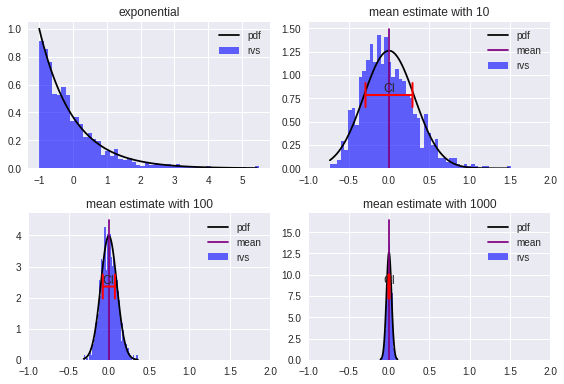

In [5]:
# Mean estimate of an exponential random variable

N = 1000

expon = sp.stats.expon(loc=-1.)
sample_sizes = (None, 10, 100, 1000)
mean, var = expon.stats("mv")
std = np.sqrt(var)

for k, sample_size in enumerate(sample_sizes):
    plt.subplot(2,2,k+1)
    if sample_size:
        rvs = expon.rvs(size=[sample_size, N]).mean(axis=0)
        dist = sp.stats.norm(loc=0., scale=1./np.sqrt(sample_size))
        plot_hist_dist(
            rvs,
            dist,
            mean=mean,
            confidence_interval=[mean - np.sqrt(var / sample_size), mean + np.sqrt(var / sample_size)],
            title='mean estimate with {:d}'.format(sample_size),
        )
        plt.xlim([-1, 2])
    else:
        plot_hist_dist(expon.rvs(size=N), expon, title='exponential')

plt.tight_layout()

## Confidence Intervals and Probabilities

We define the $z$-$\sigma$ **confidence interval** or $z$-standard-deviation **confidence interval** (where $z \ge 0$) to be the interval
$$ [\overline X - zs, \overline X + zs] \,.$$

If we assume the mean estimate is normally distributed, then we can use the statistics of the normal distribution to compute the probability that the mean estimate falls within the $z$-$\sigma$ confidence interval.  If $n(x\mid\mu,\sigma)$ is the normal pdf with mean $\mu$ and standard deviation $\sigma$, then the probability the mean falls within the $z$-$\sigma$ confidence interval is

$$ \int_{\overline X - zs}^{\overline X + zs} n(x \mid \overline X, s)dx = \int_{- z}^{z} n(x \mid 0, 1)dx = N(z) - N(-z) $$
where $N$ is the cumulative normal distribution.  We usually choose $z$ to be 2 (~95% confidence interval) or 3 (~99% confidence interval).

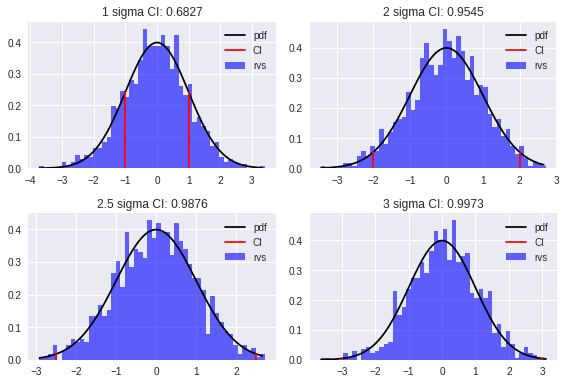

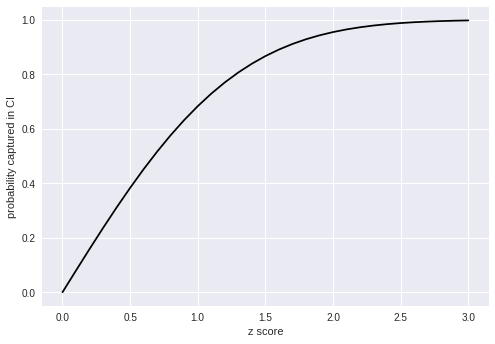

In [6]:
# Confidence intervals at various rates

N = 1000

norm = sp.stats.norm()

zs = (1, 2, 2.5, 3)

for k, z in enumerate(zs):
    plt.subplot(2,2,k+1)
    plot_hist_dist(norm.rvs(size=N), norm)
    plt.plot([-z, -z], [0, norm.pdf(-z)], 'r', label='CI')
    plt.plot([z, z], [0, norm.pdf(z)], 'r')
    prob = norm.cdf(z) - norm.cdf(-z)
    plt.title('{} sigma CI: {:.4f}'.format(z, prob))
    plt.legend()

plt.tight_layout()

plt.figure()
z=np.arange(0, 3., .1-1e-9)
plt.plot(z, norm.cdf(z) - norm.cdf(-z), color='black')
plt.xlabel('z score')
plt.ylabel('probability captured in CI')

## Standard Error of Variance Estimate

The mean estimator behaves normally.  How do the variance estimator (or other estimators) behave?  For normally distributed data, the variance estimator behaves as a chi-squared distribution.  The $\chi^2$ distribution with $n$ degrees of freedom is the distribution given by the sum of $n$ independent standard normals squared:

$$ \chi^2(n) \sim \sum_{k=1}^n Z_k^2\,. $$


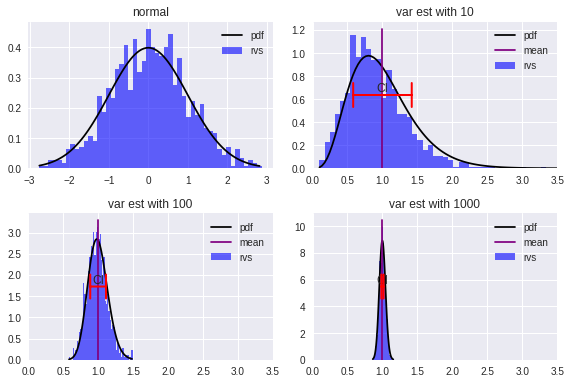

In [7]:
N = 1000
norm = sp.stats.norm()
sample_sizes = (None, 10, 100, 1000)

for k, sample_size in enumerate(sample_sizes):
    plt.subplot(2,2,k+1)
    if sample_size:
        dist = sp.stats.chi2(df=sample_size, scale=1./sample_size)
        mean, var = dist.stats("mv")        
        plot_hist_dist(
            sp.stats.norm().rvs(size=[sample_size, N]).var(axis=0),
            dist,
            mean=mean,
            confidence_interval=[mean - np.sqrt(var), mean + np.sqrt(var)],
            title='var est with {:d}'.format(sample_size),
        )
        plt.xlim([0, 3.5])
    else:
        plot_hist_dist(norm.rvs(size=N), norm, title='normal')
plt.tight_layout()

## Standard Error of Proportion

Sometimes using a normal distribution to approximate a variable does not quite make sense.  For instance, if we are estimating the success rate of a trial with binary outcomes, we can assume the underlying variable $X$ as Bernoulli with a probability of success $p$.  Recall $p$ is also the mean of the Bernoulli so the mean estimator $\hat p$ is easy to compute.  From probability theory, we know that the variance is given by $\sigma^2 = p (1-p)$.

Even though we are not modeling the underlying trial $X$ as a normal distribution, we will still model the mean estimator $\overline X$ as a normal distribution with mean $p$ and a standard error
$$ s = \sqrt{\frac{p (1-p)}{n}}\,. $$

### Rule of Three
What is the confidence interval if we have not observed a single success over $n$ Bernoulli trials?  Naively, $\hat p$ is zero and so the confidence interval seems trivial.  Rather than doing that, we ask for what values of $p$ is the likelihood of having observed no events greater than or equal to 5%:
$$ \mathbb{P}[X = 0] \ge 0.05 $$
The left hand side is just $(1-p)^n$, and so taking logs we have
$$ -np \approx n \log (1-p) \ge \ln(0.05) \approx -3 $$
and so we have
$$ p \lesssim \frac{3}{n} \,.$$

That is, the 95% confidence interval is approximately $\left[0, \frac{3}{n}\right]$.


### Other Confidence Intervals
**Question:**
1. What would be the standard error for a counting process if we were to assume a Poisson distribution?
1. What would be the standard error for an integer random variable if we were to assume a Geometric distribution?
1. What would be the standard error for a memoryless wait time if we were to assume an Exponential distribution?

In [ ]:
N = 1000
p = 0.7
sigma = np.sqrt(p * (1-p))

binom = sp.stats.binom(n=N, p=p)
bernoulli = sp.stats.bernoulli(p=p)

sample_sizes = (None, 100, 1000, 10000)

for k, sample_size in enumerate(sample_sizes):
    plt.subplot(2,2,k+1)
    if sample_size:
        dist = sp.stats.norm(loc=p, scale=sigma/np.sqrt(sample_size))
        mean, var = dist.stats("mv")
        plot_hist_dist(
            bernoulli.rvs(size=[sample_size, N]).mean(axis=0),
            dist,
            mean=mean,
            confidence_interval=[mean - np.sqrt(var), mean + np.sqrt(var)],
            title='mean est with {:d}'.format(sample_size),
        )
        plt.xlim([0.55, 0.85])
    else:
        plot_hist_dist_discrete(binom.rvs(size=N), binom, title='binomial')

plt.tight_layout()

## Bootstrapping

Estimating the error of an estimate can be difficult.  Instead of looking for closed-form solutions like the $\chi^2$ distribution, we can just numerically compute the solutions.  In the above examples, we've computed the error of the estimate by resampling from the entire population.  Sometimes this can be costly, so instead we subsample from the data we have already collected.

**Bootstrapping** involves sampling the data (with replacement), computing the estimator on the sample, and using that to infer *nonparametric* estimates of your confidence interval.  Let's suppose the statistic we want to compute on the data $X_1,\ldots,X_N$ is $\theta(X_1,\ldots,X_N)$.  For example, $\theta$ might be the mean or variance estimators we proposed above.  Next, let's call $\hat \theta_k$ the result of applying $\theta$ on the $k$-th random subsample of the data $X_1,\ldots,X_N$.  Then the variance of the estimator of $\theta$ is given by

$$ \frac{1}{B-1} \sum_{k=1}^B \left( \hat \theta_k - \frac{1}{B} \sum_{j=1}^B \hat \theta_j\ \right)^2\, $$

In [ ]:
N = 400
bootstrap_number = 200

def bootstrap_samples(rvs, estimator, bootstrap_number):
    n = len(rvs)
    return np.array([estimator(np.random.choice(rvs, size=n)) for _ in xrange(bootstrap_number)])

dists = (
    sp.stats.beta(a=2., b=4.),
    sp.stats.chi2(df=10),
    sp.stats.expon(),
    sp.stats.gamma(a=1.99),
    sp.stats.norm(),
    sp.stats.uniform(),
)

for k, dist in enumerate(dists):
    plt.subplot(3,2,k+1)
    mean, var = dist.stats("mv")
    rvs = dist.rvs(size=N)
    samples = bootstrap_samples(
        rvs,
        estimator=lambda x: np.mean(x) - rvs.mean(),
        bootstrap_number=bootstrap_number
    )
    
    norm = sp.stats.norm(loc=0., scale=np.sqrt(var / (N-1)))
    plot_hist_dist(samples, norm, title=dist.dist.name)
    
plt.tight_layout()

## Hypothesis Testing

Hypothesis testing and confidence intervals (or more broadly bootstrapping) are two sides of the same coin.  The former tells you about estimators that you've sampled and what it could be.  The latter tells you about what those estimators cannot be.  More precisely, the mantra of hypothesis testing is that it's not possible to prove something, but we can show alternatives are highly unlikely.

In hypothesis testing, we define a **null hypothesis** $H_0$ -- which is often the opposite of what we are looking for -- and then compute how unlikely it would be to observe that given the current data.  Here are a few examples:

**Example:** Let's try to prove that the mean estimate of a population $\overline X$ is greater than zero.  We may assume that if it were zero (the null hypothesis or $H_0$), it would be normally distribution with mean $0$ and standard deviation $\sigma$.  We might set $s = \frac{\hat \sigma}{\sqrt{n}}$, the square root of the estimator for variance divided by the square root of the number of samples.

We would then compute the **p value** or the probability of observing $\overline X$ *or a result that is more extreme*.  A p value of less than 5% is often taken as evidence to reject the null hypothesis.  What does more extreme mean?  Here are two common definitions:
1. **One sided test:** If we are testing whether $\overline X$ is statistically significantly greater than $\mu$, the p value would be given by
$$1-N\left(\overline X \mid \mu, \sigma^2\right) = 1-N\left(z \mid 0, 1\right)$$
where $N(x \mid \mu,\sigma^2)$ is the normal cdf with mean $\mu$ and standard deviation $\sigma$.  If we are testing whether $\overline X$ is statistically significantly less than zero, the p value would be $N\left(\overline X \mid \mu, \sigma^2\right)$.  As usual, we will probably use $\sigma = \hat \sigma$, the estimated standard deviation.
1. **Two sided test:** We are testing whether $\overline X$ is different (either greater or smaller) than $\mu$ and if this is statistically significant.  The $p$ value is given by $2 \cdot N\left(-\left|\overline X\right|  \mid  \mu, \sigma^2\right)$.

### Multiple Hypothesis Testing

Sometimes, instead of testing for just one hypothesis, we end up testing for multiple hypotheses.  This can be very dangerous and is generally something to be avoided.  For example, assume that we are rejecting null hypotheses at 5% p-values.  That is, we reject null hypotheses if, assuming they were true, we would expect to see data this extreme less than 5% of the time.  Then, if we test 20 independent null hypotheses, we'd expect to see sample data that falls outside of a 5% p-value at least once. Hence, we'd expect to (incorrectly) reject 1 null hypothesis even in the event that all 20 null hypotheses were true.

There are corrections for this (for example, the [Bonferroni correction](https://en.wikipedia.org/wiki/Holm%E2%80%93Bonferroni_method)).

In [ ]:
mu_actual = .2
mu_hypothesis = 0.
N = 100

X = sp.stats.norm(loc=mu_actual).rvs(size=N)
norm = sp.stats.norm(loc=mu_hypothesis, scale=1. / np.sqrt(len(X)))
bootstrap_rvs = bootstrap_samples(X, np.mean, 1000)
def two_sided_p_value(rvs):
    return 2 * norm.cdf(-np.abs(rvs.mean()))

title = 'Hypothesis pdf vs bootstrapped means.  p-value {}'.format(two_sided_p_value(X))
plot_hist_dist(bootstrap_rvs, norm, title=title)

## Hypothesis Testing Two Means

A common question we may have is whether $\overline X$, the mean of $X_1, \ldots, X_m$ and $\overline Y$, the mean of $Y_1, \ldots, Y_n$ are different.  From above, we know that

$$ \overline X \longrightarrow N\left(\mu_X, \frac{\sigma^2_X}{m} \right) \qquad \overline Y \longrightarrow N\left(\mu_Y, \frac{\sigma^2_Y}{n} \right)\,. $$

Because we know that the sum of two normal distributions is also normal, we know that

$$ \overline X - \overline Y \longrightarrow N\left(\mu_X - \mu_Y, \frac{\sigma^2_X}{m} + \frac{\sigma^2_Y}{n} \right)\,. $$

We can use the above to compute a z score for the difference $\overline X - \overline Y$.  This tells us that we can easily hypothesize that the means are the same.

**Questions:**
1. How do we hypothesis test if $\overline X > \overline Y$ for a specific p value?
1. How do the formulas change if we model the underlying variables $X$ and $Y$ as Bernoulli trials?

## Hypothesis Testing for Counts

If we have a counting process where the Poisson assumptions are reasonable, we can apply a $\chi^2$ test to check if the counts equal some expected means.  If we hypothesize $H_0$ that $X_1, \ldots, X_n$ are independent Poisson random variables with expected means $\lambda_1, \ldots, \lambda_n$, we can use this as a basis for hypothesis testing.  Because we know that the mean and variance of $X_k$ is $\lambda_k$, we know that
$$ \frac{(X_k - \lambda_k)^2}{\lambda_k} $$
would be a non-negative random variable with expected value 1.  It asymptotically approaches the square of a standard normal.  Therefore, asymptotically,
$$ \sum_{k=1}^n \frac{(X_k - \lambda_k)^2}{\lambda_k} \sim \chi^2(n-1)$$

Notionally, this is because we are constraining $\sum_k X_k = \sum_k \lambda_k$.
We can easily test our hypothesis $H_0$ by testing the p value and rejecting sufficiently extreme p values.

**Example:** If we have counts broken up by two variables $X_{ij}$, we can apply the above to study independence.  For example, $i$ may denote whether the person is male or female, and $j$ may denote whether they are left handed, right-handed, or ambidextrous.  Then $X_{ij}$ would denote the number of people of that sex and handedness in a sample population.  We can use the $\chi^2$ test to study whether sex and handedness are correlated.  If they are not, we expect the levels to be given by
$$ \lambda_{ij} = \frac{\hat \lambda_{i\cdot} \hat \lambda_{\cdot j}}{\hat  \lambda} $$
where
$$ \hat \lambda_{i\cdot} = \sum_{j'} X_{i j'} \qquad \hat \lambda_{\cdot j} = \sum_{i'} X_{i' j} \qquad \hat \lambda = \sum_{i'j'} \lambda_{i'j'}\,. $$
With a little bit of math, we can see that asymptotically
$$ \sum_{k=1}^n \frac{(X_k - \lambda_k)^2}{\lambda_k} \sim \chi^2((r-1)(c-1))$$
where $r$ is the number of rows (i.e. the number of possible values of $i$; 2 for sex) and $c$ is the number of columns (i.e. the number of possible values of $j$; 3 for handedness).

## Determining Distributions

One common question is to have data $X_1, \ldots, X_n$ and wonder whether it has the same distribution as a hypothetical random variable $Y$.  One way to solve this problem is to take the quantile estimate of the points $X_1, \ldots, X_n$ and compare it to the quantile function $q_Y$ of $Y$.  That is, we plot the sorted points $\underline X_1, \ldots, \underline X_n$ (which form the approximate quantile function) and the points $q_Y(1/n), \ldots, q_Y(1)$ (or those points of the theoretical quantile function for $Y$).  In other words, we're plotting the points
$$ (\underline X_1, q_Y(1/n)), (\underline X_2, q_Y(2/n))\ldots, (\underline X_n, q_Y(1))\,. $$
Remember that $q_Y(U)$ has the same distribution as $Y$ so if $X$ and $Y$ share the same distribution, then these two sets of points (which are quantile approximations) should conform to the straight line $y=x$.

**Practical Usage:**
- It turns out that `scipy` will do this for us using the function `probplot`.
- It will also gives us the $R^2$ of this fit.  The closer to $1$, the more likely $X$ has the distribution of $Y$.
- Finally, don't forget that large quantiles can be noisy, so don't be surprised to see a large amount of variation near the tails.
- These are often called Q-Q plots, for quantile-quantile plots.
- Q-Q plots are very clear but you can also apply the [Kolmogorov-Smirnov](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) test, which essentially formulates and automates the testing of Q-Q plots.  This is handled by the function [`scipy.stats.ktest`](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html).

In [ ]:
# Two-sided distributions and their plots

dists = (sp.stats.norm(), sp.stats.t(df=2))

for k, distx in enumerate(dists):
    for j, disty in enumerate(dists):
        plt.subplot(len(dists), len(dists), 1 + len(dists)*k + j)
        rvs = distx.rvs(size=1000)
        sp.stats.probplot(rvs, dist=disty, plot=plt)
        plt.title('{} rvs with {} quantile'.format(distx.dist.name, disty.dist.name))
plt.tight_layout()

In [ ]:
# One-sided distributions and their plots

dists = (sp.stats.expon(), sp.stats.gamma(6.))

for k, distx in enumerate(dists):
    for j, disty in enumerate(dists):
        plt.subplot(len(dists), len(dists), 1 + len(dists)*k + j)
        rvs = distx.rvs(size=1000)
        sp.stats.probplot(rvs, dist=disty, plot=plt)
        plt.title('{} rvs with {} quantile'.format(distx.dist.name, disty.dist.name))
plt.tight_layout()

*Copyright &copy; 2016 The Data Incubator.  All rights reserved.*